<a href="https://colab.research.google.com/github/Mrsnellek/MSDS_686_22F8W2/blob/23S8W1/MSDS%20686/Week_6/Week_6_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis Assignment
## Adapted from Deep Learning with Python (2021)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import shutil
import string
import tensorflow as tf
from keras import models, layers, backend, Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import TextVectorization, IntegerLookup, Bidirectional, LSTM
from keras.utils import text_dataset_from_directory
from sklearn.model_selection import train_test_split

np.random.seed(1)

Download and extract the data.

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
!tar -xf aclImdb_v1.tar.gz

We will removed the unneeded unsup directory

In [ ]:
!rm -r aclImdb/train/unsup
!rm aclImdb_v1.tar.gz

We will create a validation folder with validation images from the training images


In [ ]:
for category in ("neg", "pos"):
  os.makedirs("aclImdb/val/" + category)
  files = os.listdir("aclImdb/train/" + category)
  np.random.shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move("aclImdb/train/" + category + "/" + fname,
                "aclImdb/val/" + category + "/" + fname)

Just like with our image data we will use flow from directory so we are not using too much memory

In [ ]:
batch_size = 32
train_flow = text_dataset_from_directory("aclImdb/train", batch_size = batch_size)
val_flow = text_dataset_from_directory("aclImdb/val", batch_size = batch_size)
test_flow = text_dataset_from_directory("aclImdb/test", batch_size = batch_size)


We can inspect the first element of data flowing from the training directory

In [ ]:
(x, y) = next(iter(train_flow))

print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x[0] input text: ", x[0])
print("y targets: ", y)

There is some puncuation and `<br /><br />` values that we should remove.  The below function will remove those features.

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

In [ ]:
check_train = train_flow.map(lambda x, y: (custom_standardization(x), y))

In [ ]:
(x, y) = next(iter(check_train))
print("x input text: ", x[0])

Now we will work on vectorizing the `x` text data.  We will define the number of most common tokens, words, or n-grams that we will use to build our model.  Below, we will start with the 20000 most common words or n-grams.  This will make sure we are not modeling on spelling mistakes or words that only appear once in the data -- in other words, we do not want to model 'noise'.

In [ ]:
# This removes the y targets.  
text_only_train = train_flow.map(lambda x, y: x)

Now that we have removed the `y` targets from the data and removed punctuation and HTML tags, we can begin to vectorize the data. We will choose 20,000 of the most common words or n-grams.  We will normalize the output using [TF-IDF](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) normalization methods.

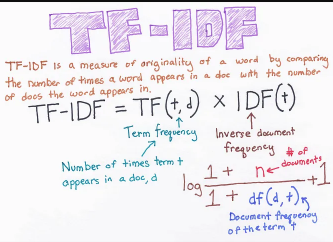

In [ ]:
max_tokens = 20000
text_vectorization = TextVectorization(
    standardize = custom_standardization,
    ngrams = 2,
    max_tokens = max_tokens,
    output_mode = 'tf_idf'
)

In [ ]:
# This will create a vector that we will use to index our text inputs with values 
# between 0 and 20,000.
text_vectorization.adapt(text_only_train)
vocab = text_vectorization.get_vocabulary()
vocab[100:125]

In [ ]:
# Appy text_vecorization to the x input text data, but not the y targets
tfidf_train = train_flow.map(lambda x, y: (text_vectorization(x), y))
tfidf_val = val_flow.map(lambda x, y: (text_vectorization(x), y))
tfidf_test = test_flow.map(lambda x, y: (text_vectorization(x), y))

Now we apply the `text_vectorization` to each of the `x` text inputs as they flowed from our directories.  Below, you can see the outputs.  The `x` data is now vectorized and there is a normalized TF-IDF value for each word or n-gram found in the text.

In [ ]:
(x, y) = next(iter(tfidf_train))
print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x input text: ", x[0])
print("y target: ", y)

Now we can build our model

In [ ]:
def text_model():
  backend.clear_session()
  model = models.Sequential()
  model.add(layers.Dense(16, activation = 'relu', input_shape = (max_tokens,)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'rmsprop',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])
  return model

Now we apply our model to the data.

In [ ]:
model = text_model()
model.fit(tfidf_train, validation_data = tfidf_val, 
          epochs = 10, 
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])
model.evaluate(tfidf_test)

The above model was a bag-of-words approach with 2-grams.  The bag-of-words approach does not consider the word order beyond the 2-grams. Now we will add an embedding layer which turns [one-hot-encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) words into dense "word vectors" or "[word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)".  We will also add an [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) layer for added word-order awareness.

Our word vectors will be 128-dimensional -- much more reasonable than 20,000!

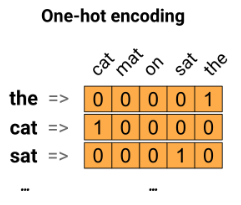 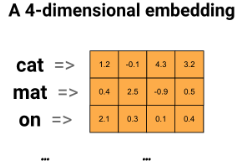

In [ ]:
max_length = 600        # Maximum allowable length of an input document (in tokens)
max_tokens = 20000
text_embedding = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length = max_length
)

In [ ]:
# This will create a vector that we will use to index our text inputs with values 
# between 0 and 20,000.
text_embedding.adapt(text_only_train)

In [ ]:
embed_train = train_flow.map(lambda x, y: (text_embedding(x), y))
embed_val = val_flow.map(lambda x, y: (text_embedding(x), y))
embed_test = test_flow.map(lambda x, y: (text_embedding(x), y))

In [ ]:
(x, y) = next(iter(embed_train))
print("input shape: ", x.shape)
print("input type: ", x.dtype)
print("targets shape: ", y.shape)
print("targets type: ", y.dtype)
print("x input text: ", x[0])
print("y input text: ", y)

In [ ]:
backend.clear_session()
# Build a model using the Functional API
inputs = Input(shape=(None,), dtype="int64")
x = layers.Embedding(max_tokens, 128) (inputs) # Here we will learn the word emdeddings
x = layers.Bidirectional(layers.LSTM(32)) (x)
x = layers.Dropout(0.5) (x)
x = layers.Dense(64, activation="relu") (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation = 'sigmoid') (x)
model = Model(inputs, outputs)
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

In [ ]:
model.fit(embed_train, validation_data = embed_val, 
          epochs = 10, 
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])
model.evaluate(embed_test)

Word embeddings and LSTM models can  inprove text models. You can also use pretrained word embeddings such as [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) or [word2vec](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/rvecs.pdf).  Using these pretained embeddings will decrease run time and likely increase accuracy.

The *Transformer* model architecure began being favored over *recurrent neural networks* (RNNs) starting in 2017. Here is the [seminal paper](https://arxiv.org/pdf/1706.03762.pdf) that introduced transformer neural networks.

We will not cover Transformers this week but you are welcome to explore and utilize transformers in your assignment.


# Your turn

Your assignment is to download and perform sentiment classification of coronavirus-related tweets.  The [dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification) is part of a Kaggle competition.  You will need to download the Kaggle API JSON file and upload it to Google Colab.  I have provided the code you need to download, unzip, and organize the tweets so you can perform NLP classification.

In [ ]:
# Download and innsall Kaggle package
! pip install kaggle -q

In [ ]:
# Make a Kaggle dirrectory
! mkdir ~/.kaggle

#### Upload your kaggle.json API file

In [ ]:
# Copy your kaggle.json file to the newly created Kaggle folder
! cp kaggle.json ~/.kaggle/

In [ ]:
# Change permission of the the .json file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
! kaggle datasets download -d datatattle/covid-19-nlp-text-classification

In [ ]:
# Unzip the dataset
! unzip covid-19-nlp-text-classification.zip

In [ ]:
# Load the .csv datasets.  View the number of tweets in each file. 
cv_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
cv_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
print(len(cv_train))
print(len(cv_test))
print(cv_train.head())
print(cv_train['Sentiment'].unique())

We will simplify the problem by creating 3 classes: positive, neutral, and negative.

In [ ]:
cv_train['Sentiment']=cv_train['Sentiment'].replace('Extremely Positive','Positive')
cv_train['Sentiment']=cv_train['Sentiment'].replace('Extremely Negative','Negative')

cv_test['Sentiment']=cv_test['Sentiment'].replace('Extremely Positive','Positive')
cv_test['Sentiment']=cv_test['Sentiment'].replace('Extremely Negative','Negative')

In [ ]:
# Create CV train and validation folders
for category in cv_train['Sentiment'].unique():
  os.makedirs("cv/train/" + category)
  os.makedirs("cv/val/" + category)

In [ ]:
# Place each tweet into each folder as a .txt file
i = 0
for category in cv_train['Sentiment'].unique():
  for tweet in cv_train['OriginalTweet'].loc[cv_train['Sentiment'] == category]:
      with open("cv/train/" + category + "/" + str(i) + ".txt", 'w', encoding='utf-8') as my_tweet:
        i +=1
        my_tweet.write(tweet)

In [ ]:
# Split 20% of the training tweets into respective validataion folders.
for category in cv_train['Sentiment'].unique(): 
  files = os.listdir("cv/train/" + category)
  np.random.shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move("cv/train/" + category + "/" + fname,
                "cv/val/" + category + "/" + fname)

In [ ]:
# Place each test tweet into each folder as a .txt file
for category in cv_test['Sentiment'].unique():
  os.makedirs("cv/test/" + category)
i = 0
for category in cv_test['Sentiment'].unique():
  for tweet in cv_test['OriginalTweet'].loc[cv_test['Sentiment'] == category]:
      with open("cv/test/" + category + "/" + str(i) + ".txt", 'w', encoding='utf-8') as my_tweet:
        i +=1
        my_tweet.write(tweet)

In [ ]:
# Sanity check that files are in correct folders.
batch_size = 32
cv_train_flow = text_dataset_from_directory("cv/train", batch_size = batch_size, label_mode = 'categorical')
cv_val_flow = text_dataset_from_directory("cv/val", batch_size = batch_size, label_mode = 'categorical')
cv_test_flow = text_dataset_from_directory("cv/test", batch_size = batch_size, label_mode = 'categorical')

### Continue creating a model to classify the tweets into the 3 different categories.  You can try a pretrained word embeding layer, n-grams, TF-IDF, LSTM, removing stopwords, depth, sequence length, etc. Think about how you will clean the tweets and remove special characters and character artifacts.